# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [ ]:
! pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


### Experiment setup
* Here we simply load the game and check that it works

In [36]:
import gym
make_env = lambda: gym.make("LunarLander-v2")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

[2017-12-06 20:10:55,016] Making new env: LunarLander-v2


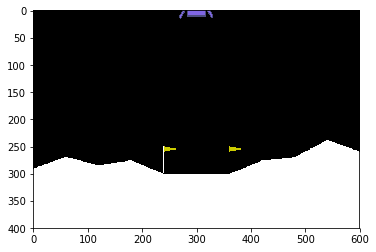

In [37]:
plt.imshow(env.render("rgb_array"))
del env

# Neural Network body

In [38]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import elu


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)


nn = DenseLayer(observation_layer, 100, nonlinearity=elu)
nn = DenseLayer(nn, 200, nonlinearity=elu)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(nn,num_units=n_actions,
                           nonlinearity=None,name="q-values")

Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [39]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [40]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)

In [41]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [42]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

[2017-12-06 20:11:05,185] Making new env: LunarLander-v2


In [43]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

actions: [[1 1 3 1 2]]
rewards: [[-1.62772081 -2.06235779 -2.06196293 -1.92526466  0.        ]]
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.5 ms


In [44]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [45]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [46]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [47]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [48]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-12-06 20:11:11,351] Making new env: LunarLander-v2
[2017-12-06 20:11:11,356] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:11:11,359] Starting new video recorder writing to /home/misha/records/openaigym.video.108.4347.video000000.mp4
[2017-12-06 20:11:12,865] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')


Episode finished after 77 timesteps with reward=-367.7605226959991


In [49]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [50]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = 0

In [51]:
from tqdm import trange

for i in trange(10000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 99/10000 [00:04<07:55, 20.80it/s][2017-12-06 20:11:20,885] Making new env: LunarLander-v2
[2017-12-06 20:11:20,888] Clearing 4 monitor files from previous run (because force=True was provided)
[2017-12-06 20:11:21,158] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')


Episode finished after 167 timesteps with reward=-59.38410318199372
Episode finished after 128 timesteps with reward=-151.22147379602174
Episode finished after 142 timesteps with reward=-105.65442319599306
iter=100	epsilon=0.910
Current score(mean over 3) = -105.420


  2%|▏         | 197/10000 [00:09<08:02, 20.32it/s][2017-12-06 20:11:25,906] Making new env: LunarLander-v2
[2017-12-06 20:11:25,909] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:11:26,090] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
  2%|▏         | 202/10000 [00:10<08:11, 19.93it/s]

Episode finished after 95 timesteps with reward=-318.5906646389142
Episode finished after 147 timesteps with reward=-492.7515777667629
Episode finished after 67 timesteps with reward=-171.0790222305397
iter=200	epsilon=0.828
Current score(mean over 3) = -327.474


  3%|▎         | 298/10000 [00:15<08:19, 19.44it/s][2017-12-06 20:11:31,506] Making new env: LunarLander-v2
[2017-12-06 20:11:31,509] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:11:31,789] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
  3%|▎         | 300/10000 [00:15<08:28, 19.09it/s]

Episode finished after 101 timesteps with reward=-273.5090387746774
Episode finished after 160 timesteps with reward=-137.3784922911736
Episode finished after 134 timesteps with reward=-232.01336860083802
iter=300	epsilon=0.754
Current score(mean over 3) = -214.300


  4%|▍         | 399/10000 [00:21<08:37, 18.54it/s][2017-12-06 20:11:37,647] Making new env: LunarLander-v2
[2017-12-06 20:11:37,650] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 142 timesteps with reward=-420.3530135064373
Episode finished after 119 timesteps with reward=-104.58177869566909


[2017-12-06 20:11:38,095] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
  4%|▍         | 403/10000 [00:22<08:48, 18.17it/s]

Episode finished after 215 timesteps with reward=-106.24797951743729
iter=400	epsilon=0.687
Current score(mean over 3) = -210.394


  5%|▍         | 499/10000 [00:27<08:44, 18.12it/s][2017-12-06 20:11:43,681] Making new env: LunarLander-v2
[2017-12-06 20:11:43,683] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:11:43,888] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
  5%|▌         | 501/10000 [00:27<08:48, 17.98it/s]

Episode finished after 95 timesteps with reward=-326.6202599030471
Episode finished after 107 timesteps with reward=0.24217981251987908
Episode finished after 137 timesteps with reward=-382.41991845961303
iter=500	epsilon=0.626
Current score(mean over 3) = -236.266


  6%|▌         | 599/10000 [00:33<08:42, 17.99it/s][2017-12-06 20:11:49,435] Making new env: LunarLander-v2
[2017-12-06 20:11:49,438] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:11:49,649] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
  6%|▌         | 601/10000 [00:33<08:46, 17.87it/s]

Episode finished after 78 timesteps with reward=-148.75566875205345
Episode finished after 142 timesteps with reward=-88.6071235952701
Episode finished after 140 timesteps with reward=-170.60364172899125
iter=600	epsilon=0.571
Current score(mean over 3) = -135.989


  7%|▋         | 699/10000 [00:39<08:43, 17.75it/s][2017-12-06 20:11:55,520] Making new env: LunarLander-v2
[2017-12-06 20:11:55,523] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:11:55,742] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')


Episode finished after 132 timesteps with reward=-275.5705376892307
Episode finished after 78 timesteps with reward=-271.3626534353059
Episode finished after 179 timesteps with reward=-338.89280730819087
iter=700	epsilon=0.522
Current score(mean over 3) = -295.275


  8%|▊         | 798/10000 [00:45<08:43, 17.57it/s][2017-12-06 20:12:01,612] Making new env: LunarLander-v2
[2017-12-06 20:12:01,615] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 110 timesteps with reward=-388.7470773515937
Episode finished after 168 timesteps with reward=-629.3074355096845


[2017-12-06 20:12:01,904] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
  8%|▊         | 802/10000 [00:45<08:47, 17.45it/s]

Episode finished after 186 timesteps with reward=-503.79373555281006
iter=800	epsilon=0.477
Current score(mean over 3) = -507.283


  9%|▉         | 898/10000 [00:51<08:45, 17.32it/s][2017-12-06 20:12:08,050] Making new env: LunarLander-v2
[2017-12-06 20:12:08,052] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:12:08,568] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
  9%|▉         | 900/10000 [00:52<08:50, 17.14it/s]

Episode finished after 369 timesteps with reward=-343.2841656652539
Episode finished after 102 timesteps with reward=-435.75554027567074
Episode finished after 195 timesteps with reward=-399.1790675061044
iter=900	epsilon=0.436
Current score(mean over 3) = -392.740


 10%|▉         | 998/10000 [00:59<08:55, 16.80it/s][2017-12-06 20:12:15,606] Making new env: LunarLander-v2
[2017-12-06 20:12:15,609] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:12:15,807] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 10%|█         | 1000/10000 [00:59<08:57, 16.74it/s]

Episode finished after 133 timesteps with reward=-335.47372487539883
Episode finished after 91 timesteps with reward=-209.66055141701875
Episode finished after 111 timesteps with reward=-196.00517471413326
iter=1000	epsilon=0.399
Current score(mean over 3) = -247.046


 11%|█         | 1098/10000 [01:06<08:57, 16.57it/s][2017-12-06 20:12:22,474] Making new env: LunarLander-v2
[2017-12-06 20:12:22,477] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 292 timesteps with reward=-802.8114823149239
Episode finished after 233 timesteps with reward=-550.3167697585864


[2017-12-06 20:12:23,224] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 11%|█         | 1102/10000 [01:07<09:03, 16.37it/s]

Episode finished after 325 timesteps with reward=-711.1702227601679
iter=1100	epsilon=0.366
Current score(mean over 3) = -688.099


 12%|█▏        | 1198/10000 [01:14<09:04, 16.18it/s][2017-12-06 20:12:30,271] Making new env: LunarLander-v2
[2017-12-06 20:12:30,274] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 112 timesteps with reward=-151.61656079425035
Episode finished after 171 timesteps with reward=-532.6626567269673


[2017-12-06 20:12:30,660] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 12%|█▏        | 1202/10000 [01:14<09:07, 16.08it/s]

Episode finished after 154 timesteps with reward=-416.05934391391884
iter=1200	epsilon=0.336
Current score(mean over 3) = -366.780


 13%|█▎        | 1298/10000 [01:22<09:10, 15.80it/s][2017-12-06 20:12:38,387] Making new env: LunarLander-v2
[2017-12-06 20:12:38,390] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 84 timesteps with reward=-415.4180823834732
Episode finished after 85 timesteps with reward=-266.5288516583267


[2017-12-06 20:12:38,728] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 13%|█▎        | 1302/10000 [01:22<09:13, 15.73it/s]

Episode finished after 319 timesteps with reward=-536.7923159645899
iter=1300	epsilon=0.309
Current score(mean over 3) = -406.246


 14%|█▍        | 1398/10000 [01:30<09:15, 15.50it/s][2017-12-06 20:12:46,458] Making new env: LunarLander-v2
[2017-12-06 20:12:46,460] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 350 timesteps with reward=-483.7985430167949
Episode finished after 181 timesteps with reward=-602.7546759151257


[2017-12-06 20:12:47,066] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 14%|█▍        | 1402/10000 [01:31<09:18, 15.38it/s]

Episode finished after 218 timesteps with reward=-461.42611395104706
iter=1400	epsilon=0.284
Current score(mean over 3) = -515.993


 15%|█▍        | 1498/10000 [01:38<09:18, 15.23it/s][2017-12-06 20:12:54,632] Making new env: LunarLander-v2
[2017-12-06 20:12:54,634] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 89 timesteps with reward=-193.1879866223631


[2017-12-06 20:12:55,089] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 15%|█▌        | 1500/10000 [01:39<09:21, 15.15it/s]

Episode finished after 253 timesteps with reward=-445.9700690925015
Episode finished after 105 timesteps with reward=-215.4226859693999
iter=1500	epsilon=0.262
Current score(mean over 3) = -284.860


 16%|█▌        | 1599/10000 [01:47<09:23, 14.91it/s][2017-12-06 20:13:03,428] Making new env: LunarLander-v2
[2017-12-06 20:13:03,431] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 260 timesteps with reward=-642.5055960599265
Episode finished after 174 timesteps with reward=-406.35471965328395

[2017-12-06 20:13:03,904] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 16%|█▌        | 1601/10000 [01:47<09:26, 14.83it/s]


Episode finished after 160 timesteps with reward=-277.0819761204
iter=1600	epsilon=0.242
Current score(mean over 3) = -441.981


 17%|█▋        | 1698/10000 [01:55<09:27, 14.64it/s][2017-12-06 20:13:12,176] Making new env: LunarLander-v2
[2017-12-06 20:13:12,178] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 243 timesteps with reward=-388.754017776989
Episode finished after 188 timesteps with reward=-479.4955639438623


[2017-12-06 20:13:12,631] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 17%|█▋        | 1702/10000 [01:56<09:28, 14.58it/s]

Episode finished after 235 timesteps with reward=-466.00936018433805
iter=1700	epsilon=0.224
Current score(mean over 3) = -444.753


 18%|█▊        | 1798/10000 [02:05<09:30, 14.38it/s][2017-12-06 20:13:21,217] Making new env: LunarLander-v2
[2017-12-06 20:13:21,220] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=23.39926069916701
Episode finished after 170 timesteps with reward=-257.8182322671339


[2017-12-06 20:13:23,577] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 18%|█▊        | 1802/10000 [02:07<09:40, 14.12it/s]

Episode finished after 221 timesteps with reward=-185.22318046243447
iter=1800	epsilon=0.207
Current score(mean over 3) = -139.881


 19%|█▉        | 1898/10000 [02:15<09:36, 14.04it/s][2017-12-06 20:13:31,358] Making new env: LunarLander-v2
[2017-12-06 20:13:31,361] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:13:31,816] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 19%|█▉        | 1900/10000 [02:15<09:38, 14.00it/s]

Episode finished after 266 timesteps with reward=-635.9805700955063
Episode finished after 203 timesteps with reward=-355.40876233828305
Episode finished after 175 timesteps with reward=-147.89768670937337
iter=1900	epsilon=0.192
Current score(mean over 3) = -379.762


 20%|█▉        | 1999/10000 [02:23<09:34, 13.92it/s][2017-12-06 20:13:39,774] Making new env: LunarLander-v2
[2017-12-06 20:13:39,777] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 176 timesteps with reward=-115.42153972934967


[2017-12-06 20:13:40,271] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 20%|██        | 2001/10000 [02:24<09:36, 13.87it/s]

Episode finished after 322 timesteps with reward=-260.51220993099366
Episode finished after 162 timesteps with reward=-308.54923007556056
iter=2000	epsilon=0.179
Current score(mean over 3) = -228.161


 21%|██        | 2099/10000 [02:31<09:30, 13.86it/s][2017-12-06 20:13:47,607] Making new env: LunarLander-v2
[2017-12-06 20:13:47,609] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 214 timesteps with reward=-225.43349823534578
Episode finished after 212 timesteps with reward=-217.07273662992682


[2017-12-06 20:13:48,070] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 21%|██        | 2103/10000 [02:32<09:31, 13.82it/s]

Episode finished after 245 timesteps with reward=-382.3315877727694
iter=2100	epsilon=0.166
Current score(mean over 3) = -274.946


 22%|██▏       | 2199/10000 [02:39<09:24, 13.81it/s][2017-12-06 20:13:55,364] Making new env: LunarLander-v2
[2017-12-06 20:13:55,367] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 189 timesteps with reward=-256.0189749534146
Episode finished after 178 timesteps with reward=-265.57523437061366


[2017-12-06 20:13:55,831] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 22%|██▏       | 2201/10000 [02:39<09:26, 13.77it/s]

Episode finished after 300 timesteps with reward=-404.12221857376665
iter=2200	epsilon=0.155
Current score(mean over 3) = -308.572


 23%|██▎       | 2299/10000 [02:46<09:19, 13.77it/s][2017-12-06 20:14:03,069] Making new env: LunarLander-v2
[2017-12-06 20:14:03,071] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:14:03,208] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 23%|██▎       | 2301/10000 [02:47<09:19, 13.76it/s]

Episode finished after 86 timesteps with reward=-440.26119120316025
Episode finished after 76 timesteps with reward=-377.9536631279919
Episode finished after 86 timesteps with reward=-492.64973268044247
iter=2300	epsilon=0.145
Current score(mean over 3) = -436.955


 24%|██▍       | 2398/10000 [02:54<09:13, 13.73it/s][2017-12-06 20:14:10,854] Making new env: LunarLander-v2
[2017-12-06 20:14:10,856] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:14:11,095] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 24%|██▍       | 2400/10000 [02:55<09:14, 13.71it/s]

Episode finished after 192 timesteps with reward=-199.52851049270686
Episode finished after 109 timesteps with reward=-157.60429816741052
Episode finished after 91 timesteps with reward=-480.2053447639872
iter=2400	epsilon=0.136
Current score(mean over 3) = -279.113


 25%|██▍       | 2498/10000 [03:02<09:07, 13.71it/s][2017-12-06 20:14:18,353] Making new env: LunarLander-v2
[2017-12-06 20:14:18,355] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:14:18,490] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 25%|██▌       | 2502/10000 [03:02<09:07, 13.71it/s]

Episode finished after 88 timesteps with reward=-345.9061236786089
Episode finished after 81 timesteps with reward=-414.04457333283233
Episode finished after 75 timesteps with reward=-474.66647563303485
iter=2500	epsilon=0.128
Current score(mean over 3) = -411.539


 26%|██▌       | 2598/10000 [03:09<08:59, 13.73it/s][2017-12-06 20:14:25,423] Making new env: LunarLander-v2
[2017-12-06 20:14:25,426] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 288 timesteps with reward=-290.3343241573765
Episode finished after 111 timesteps with reward=-141.73064200629273


[2017-12-06 20:14:26,020] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 26%|██▌       | 2602/10000 [03:10<09:00, 13.69it/s]

Episode finished after 308 timesteps with reward=-257.6910738153774
iter=2600	epsilon=0.121
Current score(mean over 3) = -229.919


 27%|██▋       | 2698/10000 [03:17<08:53, 13.69it/s][2017-12-06 20:14:33,253] Making new env: LunarLander-v2
[2017-12-06 20:14:33,255] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:14:33,511] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 27%|██▋       | 2700/10000 [03:17<08:53, 13.68it/s]

Episode finished after 103 timesteps with reward=-28.6390279988302
Episode finished after 76 timesteps with reward=-523.5776908509397
Episode finished after 219 timesteps with reward=-332.0133851936489
iter=2700	epsilon=0.114
Current score(mean over 3) = -294.743


 28%|██▊       | 2798/10000 [03:24<08:46, 13.69it/s][2017-12-06 20:14:40,640] Making new env: LunarLander-v2
[2017-12-06 20:14:40,642] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 257 timesteps with reward=-160.34896580689295
Episode finished after 237 timesteps with reward=-160.83531696977013


[2017-12-06 20:14:41,643] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 28%|██▊       | 2802/10000 [03:25<08:48, 13.62it/s]

Episode finished after 453 timesteps with reward=-366.9504507428664
iter=2800	epsilon=0.108
Current score(mean over 3) = -229.378


 29%|██▉       | 2898/10000 [03:32<08:40, 13.64it/s][2017-12-06 20:14:48,650] Making new env: LunarLander-v2
[2017-12-06 20:14:48,653] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 173 timesteps with reward=-367.5826565500918
Episode finished after 178 timesteps with reward=-282.0079352514375


[2017-12-06 20:14:49,050] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 29%|██▉       | 2902/10000 [03:33<08:41, 13.62it/s]

Episode finished after 244 timesteps with reward=-252.14801081099978
iter=2900	epsilon=0.102
Current score(mean over 3) = -300.580


 30%|██▉       | 2998/10000 [03:40<08:35, 13.60it/s][2017-12-06 20:14:56,734] Making new env: LunarLander-v2
[2017-12-06 20:14:56,736] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 142 timesteps with reward=-286.12644931982356
Episode finished after 202 timesteps with reward=-154.6630527205774


[2017-12-06 20:14:57,075] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 30%|███       | 3002/10000 [03:41<08:35, 13.58it/s]

Episode finished after 187 timesteps with reward=-298.30311635137923
iter=3000	epsilon=0.097
Current score(mean over 3) = -246.364


 31%|███       | 3098/10000 [03:48<08:28, 13.57it/s][2017-12-06 20:15:04,513] Making new env: LunarLander-v2
[2017-12-06 20:15:04,515] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 215 timesteps with reward=-256.33931061012197
Episode finished after 332 timesteps with reward=-451.29705759555327


[2017-12-06 20:15:05,340] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 31%|███       | 3102/10000 [03:49<08:30, 13.52it/s]

Episode finished after 291 timesteps with reward=-171.72939423773204
iter=3100	epsilon=0.093
Current score(mean over 3) = -293.122


 32%|███▏      | 3198/10000 [03:57<08:24, 13.47it/s][2017-12-06 20:15:13,664] Making new env: LunarLander-v2
[2017-12-06 20:15:13,668] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 306 timesteps with reward=-445.7192082864357
Episode finished after 208 timesteps with reward=-306.63250508578875

[2017-12-06 20:15:14,421] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 32%|███▏      | 3202/10000 [03:58<08:26, 13.43it/s]


Episode finished after 320 timesteps with reward=-431.89038618541076
iter=3200	epsilon=0.089
Current score(mean over 3) = -394.747


 33%|███▎      | 3299/10000 [04:07<08:22, 13.33it/s][2017-12-06 20:15:23,619] Making new env: LunarLander-v2
[2017-12-06 20:15:23,622] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 163 timesteps with reward=-323.1528061831493


[2017-12-06 20:15:24,075] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 33%|███▎      | 3301/10000 [04:08<08:23, 13.31it/s]

Episode finished after 284 timesteps with reward=-200.18103580560114
Episode finished after 115 timesteps with reward=-159.86297189398334
iter=3300	epsilon=0.085
Current score(mean over 3) = -227.732


 34%|███▍      | 3399/10000 [04:16<08:17, 13.26it/s][2017-12-06 20:15:32,553] Making new env: LunarLander-v2
[2017-12-06 20:15:32,556] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 285 timesteps with reward=-182.99896294150614
Episode finished after 248 timesteps with reward=-224.19806181468303


[2017-12-06 20:15:33,564] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 34%|███▍      | 3401/10000 [04:17<08:19, 13.20it/s]

Episode finished after 400 timesteps with reward=-284.9488060368361
iter=3400	epsilon=0.082
Current score(mean over 3) = -230.715


 35%|███▍      | 3499/10000 [04:25<08:13, 13.18it/s][2017-12-06 20:15:41,690] Making new env: LunarLander-v2
[2017-12-06 20:15:41,693] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 191 timesteps with reward=-216.09216951132447
Episode finished after 220 timesteps with reward=-374.5071321357087


[2017-12-06 20:15:42,197] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 35%|███▌      | 3501/10000 [04:26<08:14, 13.15it/s]

Episode finished after 243 timesteps with reward=-240.32907805578486
iter=3500	epsilon=0.079
Current score(mean over 3) = -276.976


 36%|███▌      | 3599/10000 [04:33<08:07, 13.14it/s][2017-12-06 20:15:50,054] Making new env: LunarLander-v2
[2017-12-06 20:15:50,057] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 155 timesteps with reward=-256.1246625629873
Episode finished after 260 timesteps with reward=-244.47860993440483


[2017-12-06 20:15:50,735] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 36%|███▌      | 3601/10000 [04:34<08:08, 13.10it/s]

Episode finished after 262 timesteps with reward=-131.71661273761256
iter=3600	epsilon=0.076
Current score(mean over 3) = -210.773


 37%|███▋      | 3699/10000 [04:44<08:04, 13.02it/s][2017-12-06 20:16:00,307] Making new env: LunarLander-v2
[2017-12-06 20:16:00,310] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 296 timesteps with reward=-296.7318469323874


[2017-12-06 20:16:01,170] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 37%|███▋      | 3701/10000 [04:45<08:05, 12.98it/s]

Episode finished after 221 timesteps with reward=-314.8447683791275
Episode finished after 259 timesteps with reward=-354.41154687444964
iter=3700	epsilon=0.073
Current score(mean over 3) = -321.996


 38%|███▊      | 3799/10000 [04:53<07:58, 12.96it/s][2017-12-06 20:16:09,199] Making new env: LunarLander-v2
[2017-12-06 20:16:09,202] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 87 timesteps with reward=-829.5817101730967
Episode finished after 215 timesteps with reward=-62.53567177239532


[2017-12-06 20:16:09,579] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 38%|███▊      | 3801/10000 [04:53<07:58, 12.95it/s]

Episode finished after 235 timesteps with reward=-412.3215891354559
iter=3800	epsilon=0.071
Current score(mean over 3) = -434.813


 39%|███▉      | 3898/10000 [05:02<07:52, 12.90it/s][2017-12-06 20:16:18,369] Making new env: LunarLander-v2
[2017-12-06 20:16:18,372] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 214 timesteps with reward=-338.75560776679697


[2017-12-06 20:16:19,022] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 39%|███▉      | 3900/10000 [05:02<07:53, 12.87it/s]

Episode finished after 290 timesteps with reward=-251.0486674668817
Episode finished after 224 timesteps with reward=-178.48153262321892
iter=3900	epsilon=0.069
Current score(mean over 3) = -256.095


 40%|███▉      | 3999/10000 [05:11<07:47, 12.84it/s][2017-12-06 20:16:27,567] Making new env: LunarLander-v2
[2017-12-06 20:16:27,574] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 211 timesteps with reward=-139.5060174907369


[2017-12-06 20:16:28,403] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 40%|████      | 4000/10000 [05:12<07:48, 12.81it/s]

Episode finished after 320 timesteps with reward=-294.56676798607236
Episode finished after 163 timesteps with reward=-123.23225631326736
iter=4000	epsilon=0.067
Current score(mean over 3) = -185.768


 41%|████      | 4099/10000 [05:20<07:41, 12.78it/s][2017-12-06 20:16:36,991] Making new env: LunarLander-v2
[2017-12-06 20:16:36,994] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 189 timesteps with reward=-378.57387441375846
Episode finished after 196 timesteps with reward=-222.26900415234718


[2017-12-06 20:16:37,498] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 41%|████      | 4101/10000 [05:21<07:42, 12.76it/s]

Episode finished after 268 timesteps with reward=-230.02543530690204
iter=4100	epsilon=0.066
Current score(mean over 3) = -276.956


 42%|████▏     | 4199/10000 [05:29<07:34, 12.75it/s][2017-12-06 20:16:45,444] Making new env: LunarLander-v2
[2017-12-06 20:16:45,448] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 152 timesteps with reward=-291.1914514361015


[2017-12-06 20:16:45,951] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 42%|████▏     | 4201/10000 [05:29<07:35, 12.73it/s]

Episode finished after 226 timesteps with reward=-421.34582878370435
Episode finished after 184 timesteps with reward=-242.02581606929863
iter=4200	epsilon=0.064
Current score(mean over 3) = -318.188


 43%|████▎     | 4298/10000 [05:37<07:27, 12.74it/s][2017-12-06 20:16:53,626] Making new env: LunarLander-v2
[2017-12-06 20:16:53,629] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 209 timesteps with reward=-385.6656313366037
Episode finished after 246 timesteps with reward=-90.91970808049642

[2017-12-06 20:16:54,072] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 43%|████▎     | 4302/10000 [05:38<07:27, 12.72it/s]


Episode finished after 166 timesteps with reward=-285.98591719697123
iter=4300	epsilon=0.063
Current score(mean over 3) = -254.190


 44%|████▍     | 4399/10000 [05:46<07:20, 12.70it/s][2017-12-06 20:17:02,410] Making new env: LunarLander-v2
[2017-12-06 20:17:02,413] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 245 timesteps with reward=-117.04851433946855
Episode finished after 207 timesteps with reward=-383.3492453219359


[2017-12-06 20:17:02,968] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 44%|████▍     | 4401/10000 [05:46<07:21, 12.68it/s]

Episode finished after 147 timesteps with reward=-101.65977914790115
iter=4400	epsilon=0.062
Current score(mean over 3) = -200.686


 45%|████▍     | 4499/10000 [05:55<07:14, 12.67it/s][2017-12-06 20:17:11,204] Making new env: LunarLander-v2
[2017-12-06 20:17:11,207] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 208 timesteps with reward=-486.7583430047225
Episode finished after 207 timesteps with reward=-259.46625218938004


[2017-12-06 20:17:11,681] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 45%|████▌     | 4501/10000 [05:55<07:14, 12.65it/s]

Episode finished after 241 timesteps with reward=-390.9616241211933
iter=4500	epsilon=0.061
Current score(mean over 3) = -379.062


 46%|████▌     | 4599/10000 [06:04<07:07, 12.62it/s][2017-12-06 20:17:20,545] Making new env: LunarLander-v2
[2017-12-06 20:17:20,548] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 168 timesteps with reward=-47.263476703910044
Episode finished after 147 timesteps with reward=-250.9580592031988


[2017-12-06 20:17:21,059] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 46%|████▌     | 4601/10000 [06:05<07:08, 12.60it/s]

Episode finished after 233 timesteps with reward=-387.66830531000454
iter=4600	epsilon=0.060
Current score(mean over 3) = -228.630


 47%|████▋     | 4699/10000 [06:12<07:00, 12.60it/s][2017-12-06 20:17:29,019] Making new env: LunarLander-v2
[2017-12-06 20:17:29,021] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 186 timesteps with reward=-132.9393969706022
Episode finished after 151 timesteps with reward=-105.5155213081442


[2017-12-06 20:17:29,406] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 47%|████▋     | 4701/10000 [06:13<07:00, 12.59it/s]

Episode finished after 177 timesteps with reward=-258.09775231969695
iter=4700	epsilon=0.059
Current score(mean over 3) = -165.518


 48%|████▊     | 4799/10000 [06:20<06:52, 12.61it/s][2017-12-06 20:17:36,818] Making new env: LunarLander-v2
[2017-12-06 20:17:36,821] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:17:37,254] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')


Episode finished after 233 timesteps with reward=-39.70869641858242
Episode finished after 159 timesteps with reward=-273.1269142858713
Episode finished after 165 timesteps with reward=-95.72081723980516
iter=4800	epsilon=0.058
Current score(mean over 3) = -136.185


 49%|████▉     | 4899/10000 [06:28<06:44, 12.61it/s][2017-12-06 20:17:44,699] Making new env: LunarLander-v2
[2017-12-06 20:17:44,701] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 72 timesteps with reward=-305.04696985044575


[2017-12-06 20:17:46,159] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 49%|████▉     | 4901/10000 [06:30<06:45, 12.56it/s]

Episode finished after 785 timesteps with reward=-152.14849501593795
Episode finished after 82 timesteps with reward=-643.6110482473994
iter=4900	epsilon=0.057
Current score(mean over 3) = -366.936


 50%|████▉     | 4998/10000 [06:37<06:37, 12.57it/s][2017-12-06 20:17:53,704] Making new env: LunarLander-v2
[2017-12-06 20:17:53,707] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 248 timesteps with reward=-292.1324897937899


[2017-12-06 20:17:54,532] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 50%|█████     | 5000/10000 [06:38<06:38, 12.55it/s]

Episode finished after 404 timesteps with reward=-251.4000336892116
Episode finished after 201 timesteps with reward=-281.92190103585403
iter=5000	epsilon=0.056
Current score(mean over 3) = -275.151


 51%|█████     | 5098/10000 [06:45<06:30, 12.57it/s][2017-12-06 20:18:01,907] Making new env: LunarLander-v2
[2017-12-06 20:18:01,910] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:18:02,207] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 51%|█████     | 5100/10000 [06:46<06:30, 12.56it/s]

Episode finished after 145 timesteps with reward=-249.38318346837912
Episode finished after 213 timesteps with reward=-236.43960761559543
Episode finished after 93 timesteps with reward=-187.1194316393956
iter=5100	epsilon=0.056
Current score(mean over 3) = -224.314


 52%|█████▏    | 5198/10000 [06:53<06:22, 12.56it/s][2017-12-06 20:18:10,057] Making new env: LunarLander-v2
[2017-12-06 20:18:10,059] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:18:10,280] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 52%|█████▏    | 5200/10000 [06:54<06:22, 12.55it/s]

Episode finished after 99 timesteps with reward=-32.15905748955403
Episode finished after 151 timesteps with reward=-281.74812261620616
Episode finished after 120 timesteps with reward=-263.9236296402046
iter=5200	epsilon=0.055
Current score(mean over 3) = -192.610


 53%|█████▎    | 5298/10000 [07:01<06:13, 12.57it/s][2017-12-06 20:18:17,575] Making new env: LunarLander-v2
[2017-12-06 20:18:17,578] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:18:17,859] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 53%|█████▎    | 5300/10000 [07:01<06:14, 12.57it/s]

Episode finished after 73 timesteps with reward=-499.12372704721025
Episode finished after 188 timesteps with reward=-244.8524323624976
Episode finished after 167 timesteps with reward=-228.62631589358685
iter=5300	epsilon=0.055
Current score(mean over 3) = -324.201


 54%|█████▍    | 5398/10000 [07:09<06:06, 12.57it/s][2017-12-06 20:18:25,665] Making new env: LunarLander-v2
[2017-12-06 20:18:25,668] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:18:25,859] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 54%|█████▍    | 5400/10000 [07:09<06:06, 12.56it/s]

Episode finished after 84 timesteps with reward=-283.0548462054379
Episode finished after 83 timesteps with reward=-535.9387060427205
Episode finished after 145 timesteps with reward=-72.03951231847195
iter=5400	epsilon=0.054
Current score(mean over 3) = -297.011


 55%|█████▍    | 5498/10000 [07:17<05:58, 12.56it/s][2017-12-06 20:18:33,813] Making new env: LunarLander-v2
[2017-12-06 20:18:33,816] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:18:34,031] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 55%|█████▌    | 5500/10000 [07:17<05:58, 12.56it/s]

Episode finished after 72 timesteps with reward=-496.47379346764797
Episode finished after 131 timesteps with reward=-208.01923516292885
Episode finished after 149 timesteps with reward=-200.6312517676109
iter=5500	epsilon=0.054
Current score(mean over 3) = -301.708


 56%|█████▌    | 5598/10000 [07:24<05:49, 12.58it/s][2017-12-06 20:18:41,171] Making new env: LunarLander-v2
[2017-12-06 20:18:41,173] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:18:41,886] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 56%|█████▌    | 5600/10000 [07:25<05:50, 12.56it/s]

Episode finished after 412 timesteps with reward=-415.2770220241409
Episode finished after 138 timesteps with reward=-454.93685042361824
Episode finished after 163 timesteps with reward=-219.82225584554558
iter=5600	epsilon=0.054
Current score(mean over 3) = -363.345


 57%|█████▋    | 5698/10000 [07:33<05:42, 12.57it/s][2017-12-06 20:18:49,621] Making new env: LunarLander-v2
[2017-12-06 20:18:49,624] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 108 timesteps with reward=-52.496307273303685
Episode finished after 273 timesteps with reward=-136.88146234148093


[2017-12-06 20:18:50,613] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 57%|█████▋    | 5702/10000 [07:34<05:42, 12.54it/s]

Episode finished after 582 timesteps with reward=-124.86371158215728
iter=5700	epsilon=0.053
Current score(mean over 3) = -104.747


 58%|█████▊    | 5798/10000 [07:42<05:35, 12.54it/s][2017-12-06 20:18:58,689] Making new env: LunarLander-v2
[2017-12-06 20:18:58,691] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:18:58,968] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 58%|█████▊    | 5800/10000 [07:42<05:35, 12.53it/s]

Episode finished after 191 timesteps with reward=-261.0730115049446
Episode finished after 126 timesteps with reward=-61.29583891649714
Episode finished after 115 timesteps with reward=-227.44240852777483
iter=5800	epsilon=0.053
Current score(mean over 3) = -183.270


 59%|█████▉    | 5898/10000 [07:50<05:27, 12.53it/s][2017-12-06 20:19:07,072] Making new env: LunarLander-v2
[2017-12-06 20:19:07,075] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-12-06 20:19:07,423] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 59%|█████▉    | 5900/10000 [07:51<05:27, 12.52it/s]

Episode finished after 259 timesteps with reward=-325.23256658871367
Episode finished after 157 timesteps with reward=-78.12008817741724
Episode finished after 87 timesteps with reward=-203.8639973141538
iter=5900	epsilon=0.053
Current score(mean over 3) = -202.406


 60%|█████▉    | 5999/10000 [08:03<05:22, 12.40it/s][2017-12-06 20:19:19,827] Making new env: LunarLander-v2
[2017-12-06 20:19:19,830] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 414 timesteps with reward=-132.25846727063745


[2017-12-06 20:19:21,059] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 60%|██████    | 6001/10000 [08:05<05:23, 12.37it/s]

Episode finished after 357 timesteps with reward=-67.5869416208271
Episode finished after 399 timesteps with reward=-68.76686641237602
iter=6000	epsilon=0.052
Current score(mean over 3) = -89.537


 61%|██████    | 6098/10000 [08:15<05:17, 12.31it/s][2017-12-06 20:19:31,796] Making new env: LunarLander-v2
[2017-12-06 20:19:31,798] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 200 timesteps with reward=-97.37786234436169


[2017-12-06 20:19:32,283] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 61%|██████    | 6101/10000 [08:16<05:17, 12.29it/s]

Episode finished after 279 timesteps with reward=-79.94729921917599
Episode finished after 80 timesteps with reward=-201.27514661102606
iter=6100	epsilon=0.052
Current score(mean over 3) = -126.200


 62%|██████▏   | 6198/10000 [08:25<05:10, 12.26it/s][2017-12-06 20:19:41,628] Making new env: LunarLander-v2
[2017-12-06 20:19:41,630] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 394 timesteps with reward=-158.50958312225717


[2017-12-06 20:19:43,038] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 62%|██████▏   | 6200/10000 [08:26<05:10, 12.23it/s]

Episode finished after 487 timesteps with reward=88.2910640570317
Episode finished after 152 timesteps with reward=-28.43044178241098
iter=6200	epsilon=0.052
Current score(mean over 3) = -32.883


 63%|██████▎   | 6299/10000 [08:39<05:05, 12.13it/s][2017-12-06 20:19:55,550] Making new env: LunarLander-v2
[2017-12-06 20:19:55,556] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 264 timesteps with reward=-122.9347162365215
Episode finished after 472 timesteps with reward=-247.10757312568603


[2017-12-06 20:19:58,003] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 63%|██████▎   | 6301/10000 [08:42<05:06, 12.07it/s]

Episode finished after 726 timesteps with reward=-217.6785239183059
iter=6300	epsilon=0.052
Current score(mean over 3) = -195.907


 64%|██████▍   | 6399/10000 [08:53<05:00, 11.99it/s][2017-12-06 20:20:09,980] Making new env: LunarLander-v2
[2017-12-06 20:20:09,982] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 584 timesteps with reward=-131.6502080512372
Episode finished after 1000 timesteps with reward=-267.82330430078383


[2017-12-06 20:20:14,699] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 64%|██████▍   | 6400/10000 [08:58<05:02, 11.88it/s]

Episode finished after 1000 timesteps with reward=-245.51824159929194
iter=6400	epsilon=0.052
Current score(mean over 3) = -214.997


 65%|██████▍   | 6499/10000 [09:11<04:57, 11.77it/s][2017-12-06 20:20:28,127] Making new env: LunarLander-v2
[2017-12-06 20:20:28,131] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 961 timesteps with reward=-183.87510573624664
Episode finished after 1000 timesteps with reward=-206.33500442995117


[2017-12-06 20:20:33,714] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 65%|██████▌   | 6501/10000 [09:17<05:00, 11.66it/s]

Episode finished after 391 timesteps with reward=-71.12000482432683
iter=6500	epsilon=0.051
Current score(mean over 3) = -153.777


 66%|██████▌   | 6599/10000 [09:31<04:54, 11.55it/s][2017-12-06 20:20:47,358] Making new env: LunarLander-v2
[2017-12-06 20:20:47,361] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 609 timesteps with reward=-329.54165842508655
Episode finished after 1000 timesteps with reward=-284.92392325925795


[2017-12-06 20:20:50,771] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 66%|██████▌   | 6601/10000 [09:34<04:56, 11.48it/s]

Episode finished after 570 timesteps with reward=-231.917382663402
iter=6600	epsilon=0.051
Current score(mean over 3) = -282.128


 67%|██████▋   | 6699/10000 [09:49<04:50, 11.37it/s][2017-12-06 20:21:05,556] Making new env: LunarLander-v2
[2017-12-06 20:21:05,559] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 660 timesteps with reward=-306.7420591697706


[2017-12-06 20:21:08,147] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 67%|██████▋   | 6700/10000 [09:52<04:51, 11.32it/s]

Episode finished after 692 timesteps with reward=-278.7352715243365
Episode finished after 384 timesteps with reward=-262.4593671694877
iter=6700	epsilon=0.051
Current score(mean over 3) = -282.646


 68%|██████▊   | 6798/10000 [10:03<04:44, 11.27it/s][2017-12-06 20:21:19,357] Making new env: LunarLander-v2
[2017-12-06 20:21:19,360] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 803 timesteps with reward=-226.44184906882984
Episode finished after 406 timesteps with reward=-270.89705529193907


[2017-12-06 20:21:21,646] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 68%|██████▊   | 6801/10000 [10:05<04:44, 11.23it/s]

Episode finished after 428 timesteps with reward=-211.94225545171975
iter=6800	epsilon=0.051
Current score(mean over 3) = -236.427


 69%|██████▉   | 6899/10000 [10:18<04:38, 11.15it/s][2017-12-06 20:21:35,087] Making new env: LunarLander-v2
[2017-12-06 20:21:35,089] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 678 timesteps with reward=-256.2293961389091
Episode finished after 1000 timesteps with reward=-210.75735995750986


[2017-12-06 20:21:40,265] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 69%|██████▉   | 6902/10000 [10:24<04:40, 11.06it/s]

Episode finished after 1000 timesteps with reward=-242.58641661762445
iter=6900	epsilon=0.051
Current score(mean over 3) = -236.524


 70%|██████▉   | 6998/10000 [10:35<04:32, 11.01it/s][2017-12-06 20:21:51,722] Making new env: LunarLander-v2
[2017-12-06 20:21:51,725] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 583 timesteps with reward=-212.70471691372242
Episode finished after 1000 timesteps with reward=-226.43422594233408


[2017-12-06 20:21:56,173] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 70%|███████   | 7001/10000 [10:40<04:34, 10.93it/s]

Episode finished after 1000 timesteps with reward=-201.80405100391127
iter=7000	epsilon=0.051
Current score(mean over 3) = -213.648


 71%|███████   | 7099/10000 [10:56<04:28, 10.82it/s][2017-12-06 20:22:12,329] Making new env: LunarLander-v2
[2017-12-06 20:22:12,332] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 407 timesteps with reward=224.31613780075762
Episode finished after 1000 timesteps with reward=-221.4660532203038


[2017-12-06 20:22:18,479] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 71%|███████   | 7102/10000 [11:02<04:30, 10.72it/s]

Episode finished after 895 timesteps with reward=-370.7469785092767
iter=7100	epsilon=0.051
Current score(mean over 3) = -122.632


 72%|███████▏  | 7199/10000 [11:16<04:23, 10.65it/s][2017-12-06 20:22:32,290] Making new env: LunarLander-v2
[2017-12-06 20:22:32,293] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-142.70552368709573
Episode finished after 614 timesteps with reward=-239.6051643162827


[2017-12-06 20:22:36,503] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 72%|███████▏  | 7201/10000 [11:20<04:24, 10.58it/s]

Episode finished after 590 timesteps with reward=-227.23023065558607
iter=7200	epsilon=0.051
Current score(mean over 3) = -203.180


 73%|███████▎  | 7299/10000 [11:31<04:16, 10.55it/s][2017-12-06 20:22:48,121] Making new env: LunarLander-v2
[2017-12-06 20:22:48,124] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 861 timesteps with reward=-263.6278804852419
Episode finished after 842 timesteps with reward=-284.2128845257398


[2017-12-06 20:22:53,444] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 73%|███████▎  | 7301/10000 [11:37<04:17, 10.47it/s]

Episode finished after 892 timesteps with reward=-300.23725171819706
iter=7300	epsilon=0.051
Current score(mean over 3) = -282.693


 74%|███████▍  | 7398/10000 [11:52<04:10, 10.39it/s][2017-12-06 20:23:08,424] Making new env: LunarLander-v2
[2017-12-06 20:23:08,427] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 632 timesteps with reward=-231.09249978442193
Episode finished after 1000 timesteps with reward=-132.041713357771


[2017-12-06 20:23:15,095] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 74%|███████▍  | 7402/10000 [11:59<04:12, 10.29it/s]

Episode finished after 980 timesteps with reward=-282.9217891257553
iter=7400	epsilon=0.051
Current score(mean over 3) = -215.352


 75%|███████▍  | 7498/10000 [12:11<04:04, 10.24it/s][2017-12-06 20:23:28,265] Making new env: LunarLander-v2
[2017-12-06 20:23:28,268] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 702 timesteps with reward=-249.1575920322101
Episode finished after 927 timesteps with reward=-309.29939989960235


[2017-12-06 20:23:32,350] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 75%|███████▌  | 7501/10000 [12:16<04:05, 10.19it/s]

Episode finished after 692 timesteps with reward=-225.4693324158432
iter=7500	epsilon=0.051
Current score(mean over 3) = -261.309


 76%|███████▌  | 7598/10000 [12:28<03:56, 10.15it/s][2017-12-06 20:23:44,576] Making new env: LunarLander-v2
[2017-12-06 20:23:44,579] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 838 timesteps with reward=-274.85420917598117
Episode finished after 1000 timesteps with reward=-166.33060397982948


[2017-12-06 20:23:50,281] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 76%|███████▌  | 7601/10000 [12:34<03:58, 10.08it/s]

Episode finished after 1000 timesteps with reward=-129.67409867334905
iter=7600	epsilon=0.050
Current score(mean over 3) = -190.286


 77%|███████▋  | 7698/10000 [12:47<03:49, 10.03it/s][2017-12-06 20:24:03,594] Making new env: LunarLander-v2
[2017-12-06 20:24:03,597] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-116.31490502216906
Episode finished after 1000 timesteps with reward=-159.22834271005758


[2017-12-06 20:24:08,226] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 77%|███████▋  | 7701/10000 [12:52<03:50,  9.97it/s]

Episode finished after 1000 timesteps with reward=-125.72480715413518
iter=7700	epsilon=0.050
Current score(mean over 3) = -133.756


 78%|███████▊  | 7799/10000 [13:05<03:41,  9.93it/s][2017-12-06 20:24:21,608] Making new env: LunarLander-v2
[2017-12-06 20:24:21,611] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-147.39461101190037
Episode finished after 1000 timesteps with reward=-133.39175740690646


[2017-12-06 20:24:28,507] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 78%|███████▊  | 7800/10000 [13:12<03:43,  9.84it/s]

Episode finished after 1000 timesteps with reward=-135.68303238672345
iter=7800	epsilon=0.050
Current score(mean over 3) = -138.823


 79%|███████▉  | 7899/10000 [13:26<03:34,  9.79it/s][2017-12-06 20:24:42,587] Making new env: LunarLander-v2
[2017-12-06 20:24:42,589] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 579 timesteps with reward=-198.18021638808708
Episode finished after 1000 timesteps with reward=-127.73641900501717


[2017-12-06 20:24:47,424] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 79%|███████▉  | 7902/10000 [13:31<03:35,  9.74it/s]

Episode finished after 1000 timesteps with reward=-135.59104223312522
iter=7900	epsilon=0.050
Current score(mean over 3) = -153.836


 80%|███████▉  | 7999/10000 [13:46<03:26,  9.68it/s][2017-12-06 20:25:03,025] Making new env: LunarLander-v2
[2017-12-06 20:25:03,027] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-148.9800852699523
Episode finished after 1000 timesteps with reward=-131.74629682053305


[2017-12-06 20:25:10,588] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 80%|████████  | 8001/10000 [13:54<03:28,  9.59it/s]

Episode finished after 1000 timesteps with reward=-118.89222586712732
iter=8000	epsilon=0.050
Current score(mean over 3) = -133.206


 81%|████████  | 8099/10000 [14:07<03:18,  9.56it/s][2017-12-06 20:25:23,644] Making new env: LunarLander-v2
[2017-12-06 20:25:23,647] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-121.1801902946636
Episode finished after 1000 timesteps with reward=-117.6352801764081


[2017-12-06 20:25:29,507] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 81%|████████  | 8100/10000 [14:13<03:20,  9.49it/s]

Episode finished after 1000 timesteps with reward=-72.53404246797444
iter=8100	epsilon=0.050
Current score(mean over 3) = -103.783


 82%|████████▏ | 8198/10000 [14:29<03:11,  9.43it/s][2017-12-06 20:25:45,537] Making new env: LunarLander-v2
[2017-12-06 20:25:45,539] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-101.31227867254772
Episode finished after 1000 timesteps with reward=-67.50190665618109


[2017-12-06 20:25:52,290] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 82%|████████▏ | 8202/10000 [14:36<03:12,  9.36it/s]

Episode finished after 1000 timesteps with reward=-136.1611954588926
iter=8200	epsilon=0.050
Current score(mean over 3) = -101.658


 83%|████████▎ | 8298/10000 [14:50<03:02,  9.32it/s][2017-12-06 20:26:06,261] Making new env: LunarLander-v2
[2017-12-06 20:26:06,264] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-63.10904002352703
Episode finished after 1000 timesteps with reward=-103.7929529661852


[2017-12-06 20:26:13,162] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 83%|████████▎ | 8301/10000 [14:57<03:03,  9.25it/s]

Episode finished after 1000 timesteps with reward=-72.47769003180333
iter=8300	epsilon=0.050
Current score(mean over 3) = -79.793


 84%|████████▍ | 8399/10000 [15:13<02:54,  9.19it/s][2017-12-06 20:26:29,825] Making new env: LunarLander-v2
[2017-12-06 20:26:29,828] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-98.36027219892173
Episode finished after 1000 timesteps with reward=-72.37883930252141


[2017-12-06 20:26:37,290] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 84%|████████▍ | 8400/10000 [15:21<02:55,  9.12it/s]

Episode finished after 1000 timesteps with reward=-129.44573524102856
iter=8400	epsilon=0.050
Current score(mean over 3) = -100.062


 85%|████████▍ | 8498/10000 [15:36<02:45,  9.08it/s][2017-12-06 20:26:52,425] Making new env: LunarLander-v2
[2017-12-06 20:26:52,427] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-9.459884248594477
Episode finished after 1000 timesteps with reward=-93.09927921660466


[2017-12-06 20:26:58,690] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 85%|████████▌ | 8501/10000 [15:42<02:46,  9.02it/s]

Episode finished after 1000 timesteps with reward=-81.6999876117463
iter=8500	epsilon=0.050
Current score(mean over 3) = -61.420


 86%|████████▌ | 8599/10000 [15:57<02:36,  8.98it/s][2017-12-06 20:27:13,767] Making new env: LunarLander-v2
[2017-12-06 20:27:13,769] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 817 timesteps with reward=72.55746538815556


[2017-12-06 20:27:17,300] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 86%|████████▌ | 8600/10000 [16:01<02:36,  8.95it/s]

Episode finished after 783 timesteps with reward=-206.1434800282176
Episode finished after 126 timesteps with reward=0.9550747452858843
iter=8600	epsilon=0.050
Current score(mean over 3) = -44.210


 87%|████████▋ | 8699/10000 [16:16<02:26,  8.91it/s][2017-12-06 20:27:32,721] Making new env: LunarLander-v2
[2017-12-06 20:27:32,724] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-73.39792175800972
Episode finished after 1000 timesteps with reward=-72.31778933147922


[2017-12-06 20:27:41,248] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 87%|████████▋ | 8702/10000 [16:25<02:26,  8.83it/s]

Episode finished after 1000 timesteps with reward=-46.152936644237
iter=8700	epsilon=0.050
Current score(mean over 3) = -63.956


 88%|████████▊ | 8799/10000 [16:38<02:16,  8.81it/s][2017-12-06 20:27:54,432] Making new env: LunarLander-v2
[2017-12-06 20:27:54,434] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-68.77709441227009
Episode finished after 1000 timesteps with reward=-63.71243576209078


[2017-12-06 20:28:01,065] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 88%|████████▊ | 8802/10000 [16:45<02:16,  8.76it/s]

Episode finished after 1000 timesteps with reward=-101.59982172931781
iter=8800	epsilon=0.050
Current score(mean over 3) = -78.030


 89%|████████▉ | 8898/10000 [16:56<02:05,  8.75it/s][2017-12-06 20:28:12,865] Making new env: LunarLander-v2
[2017-12-06 20:28:12,867] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 150 timesteps with reward=3.9964996143349367
Episode finished after 1000 timesteps with reward=-9.000406458791838


[2017-12-06 20:28:15,815] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')
 89%|████████▉ | 8901/10000 [16:59<02:05,  8.73it/s]

Episode finished after 591 timesteps with reward=-174.06398177472795
iter=8900	epsilon=0.050
Current score(mean over 3) = -59.689


 90%|████████▉ | 8999/10000 [17:11<01:54,  8.72it/s][2017-12-06 20:28:27,964] Making new env: LunarLander-v2
[2017-12-06 20:28:27,966] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 963 timesteps with reward=-217.78876641151027
Episode finished after 154 timesteps with reward=-5.771723771154143


[2017-12-06 20:28:30,564] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')


Episode finished after 317 timesteps with reward=227.05911483272928
iter=9000	epsilon=0.050
Current score(mean over 3) = 1.166
You win!


/home/misha/anaconda2/envs/python3env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


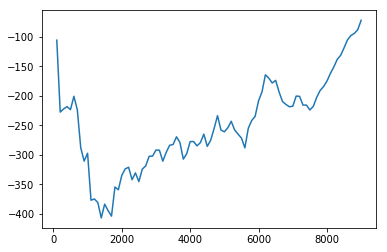

In [52]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda item:item[0]))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [54]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

[2017-12-06 20:32:14,105] Making new env: LunarLander-v2
[2017-12-06 20:32:14,112] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-12-06 20:32:14,114] Starting new video recorder writing to /home/misha/records/openaigym.video.200.4347.video000000.mp4

[2017-12-06 20:32:16,125] Starting new video recorder writing to /home/misha/records/openaigym.video.200.4347.video000001.mp4



Episode finished after 108 timesteps with reward=-36.36507844731736
Episode finished after 303 timesteps with reward=225.2444374274882
Episode finished after 1000 timesteps with reward=-60.62762860320174
Episode finished after 1000 timesteps with reward=-52.742522270854835
Episode finished after 1000 timesteps with reward=-104.46200612673321
Episode finished after 1000 timesteps with reward=-95.08679497325068


[2017-12-06 20:32:32,963] Starting new video recorder writing to /home/misha/records/openaigym.video.200.4347.video000008.mp4



Episode finished after 1000 timesteps with reward=-81.79139524587485
Episode finished after 101 timesteps with reward=-59.18993919277167
Episode finished after 553 timesteps with reward=181.63515811143327


[2017-12-06 20:32:43,603] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/misha/records')


Episode finished after 809 timesteps with reward=-87.31231269474475
average reward: [-36.365078447317359, 225.24443742748821, -60.627628603201742, -52.742522270854835, -104.46200612673321, -95.086794973250676, -81.791395245874853, -59.189939192771668, 181.63515811143327, -87.312312694744747]
